In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil

from sklearn.preprocessing import MinMaxScaler

from tqdm.notebook import tqdm

In [3]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin

In [4]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Air Passenger with vanilla RNN and LSTM

In [5]:
from u8timeseries import TimeSeries
from u8timeseries.utils import TimeSeriesDataset1D
from u8timeseries import RNN, RNNModel

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [6]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

In [7]:
def training_split(data: TimeSeries, test_ts: pd.Timestamp, val_ts: pd.Timestamp = None) -> [TimeSeries]:
    """
    in order: test, [val,] train
    """
    split_series = []
    assert data.in_range_index(test_ts), "The splitting time stamp is outside the time range"
    train, test = data.split_after(test_ts)
    split_series.append(test)
    if val_ts is not None:
        assert train.in_range_index(val_ts), "The splitting time stamp is outside the training time range"
        train, val = train.split_after(val_ts)
        split_series.append(val)
    split_series.append(train)
    return split_series

In [8]:
# Number of features/channels used as input.
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 12 # 132
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_SIZE = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [9]:
scaler = MinMaxScaler()
scaler.fit(series.values().reshape(-1, 1))
# scaler.partial_fit(np.array([[1000]]))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
test, train = training_split(series, pd.Timestamp('19580101'))

In [11]:
my_model = RNNModel('RNN', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=32, n_epochs=1200, exp_name='Air_RNN', vis_tb=True)

In [12]:
my_model.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99)

In [13]:
my_model.set_val_series(test)

In [14]:
my_model.fit(train)  # 107

Training loss: 0.0032, validation loss: 0.0365


Result of training

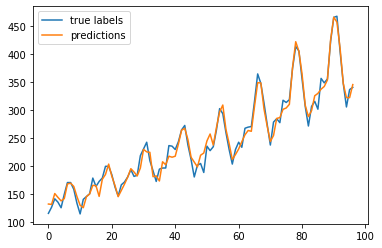

MSE: 141.476288


In [15]:
my_model.plot_result_train()

Test with horizon=1, and feeding ground truth

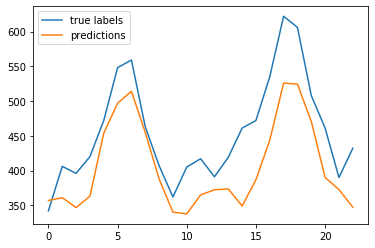

MSE: 3541.601562


In [16]:
my_model.test_series(test)

Test with horizon=38, and feeding predictions

=> loaded checkpoint (epoch 1200)


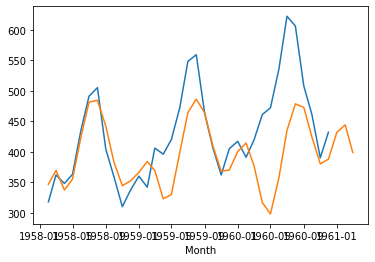

In [17]:
pred_series = my_model.predict(train, n=38)
test.plot()
pred_series.plot()

#### LSTM

In [18]:
my_model_lstm = RNNModel('LSTM', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                         batch_size=32, n_epochs=1000, exp_name='Air_LSTM', vis_tb=True)

In [19]:
my_model_lstm.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_lstm.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [20]:
my_model_lstm.set_val_series(test)

In [21]:
my_model_lstm.fit(train)  # 107

Training loss: 0.0007, validation loss: 0.0181


In [22]:
my_model_lstm = RNNModel('LSTM', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                         batch_size=32, n_epochs=2000, exp_name='Air_LSTM', vis_tb=True)

In [23]:
my_model_lstm.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_lstm.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [24]:
my_model_lstm.set_val_series(test)

In [25]:
my_model_lstm.load_from_checkpoint(is_best=False)

=> loaded checkpoint (epoch 1000)


In [26]:
my_model_lstm.fit(train)  # 107

Training loss: 0.0002, validation loss: 0.0194


Result of training

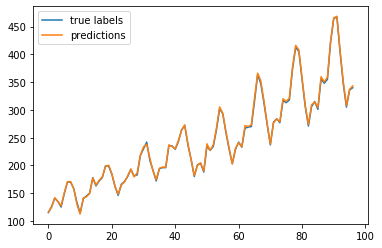

MSE: 5.055914


In [27]:
my_model_lstm.plot_result_train()

Test with horizon=1, and feeding ground truth

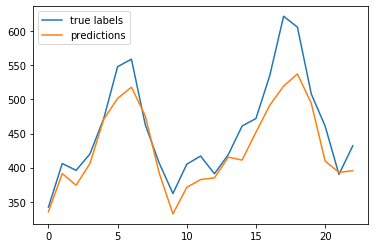

MSE: 1418.253052


In [28]:
my_model_lstm.test_series(test)

Test with horizon=38, and feeding predictions

=> loaded checkpoint (epoch 2000)


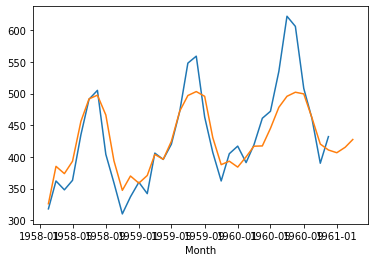

In [29]:
pred_series = my_model_lstm.predict(train, 38)
test.plot()
pred_series.plot()

In [30]:
# If recreate the model only from checkpoint, must set the train dataset too
# my_model_lstm.set_train_dataset(train)

=> loaded checkpoint (epoch 1831)


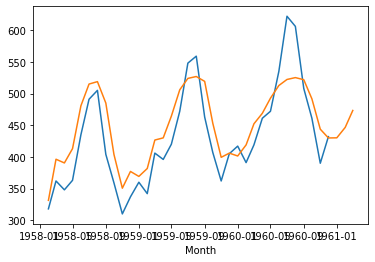

In [31]:
pred_series = my_model_lstm.predict(train, n=38, is_best=True)
test.plot()
pred_series.plot()

#### GRU

In [32]:
my_model_gru = RNNModel('GRU', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=1500, exp_name='Air_GRU', vis_tb=True)

In [33]:
my_model_gru.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_gru.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [34]:
my_model_gru.set_val_series(test)

In [35]:
my_model_gru.fit(train)  # 107

Training loss: 0.0010, validation loss: 0.0110


Result of training

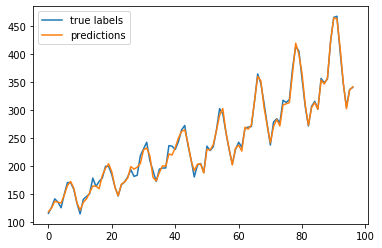

MSE: 35.461224


In [36]:
my_model_gru.plot_result_train()

Test with horizon=1, and feeding ground truth

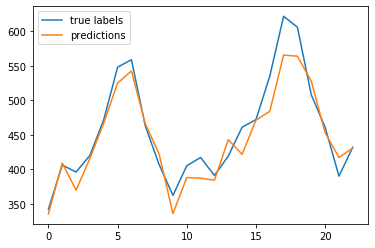

MSE: 636.154297


In [37]:
my_model_gru.test_series(test)

Test with horizon=38, and feeding predictions

=> loaded checkpoint (epoch 1491)


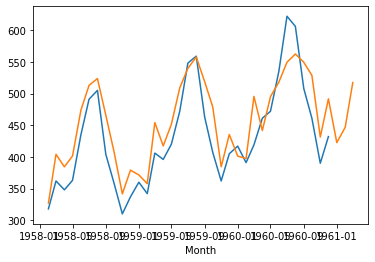

In [38]:
pred_series = my_model_gru.predict(train, n=38, is_best=True)
test.plot()
pred_series.plot()

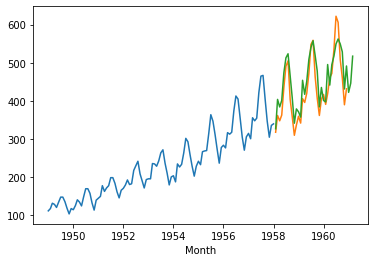

In [39]:
train.plot()
test.plot()
pred_series.plot()

__Longer output__

In [40]:
my_model_gru = RNNModel('GRU', INPUT_SIZE, OUTPUT_SIZE*12, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=1500, exp_name='Air_GRU_out12', vis_tb=True)

In [41]:
my_model_gru.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_gru.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [42]:
my_model_gru.set_val_series(test)

In [43]:
my_model_gru.fit(train)  # 107

Training loss: 0.0005, validation loss: 0.0298


Result of training

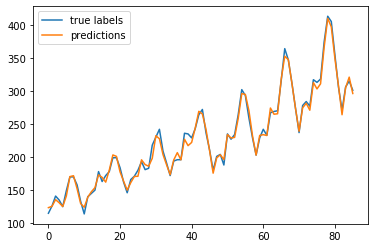

MSE: 27.798859


In [44]:
my_model_gru.plot_result_train()

Test with horizon=1, and feeding ground truth

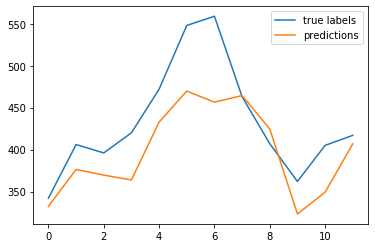

MSE: 2922.279053


In [45]:
my_model_gru.test_series(test)

Test with horizon=28, and feeding predictions

=> loaded checkpoint (epoch 571)


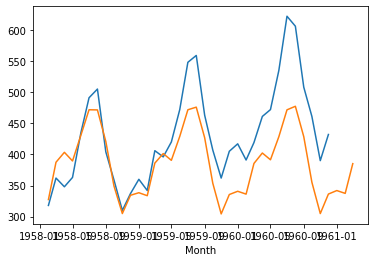

In [46]:
pred_series = my_model_gru.predict(train, n=38, is_best=True)
test.plot()
pred_series.plot()

Full output at time T

T = end of train time series

=> loaded checkpoint (epoch 1500)


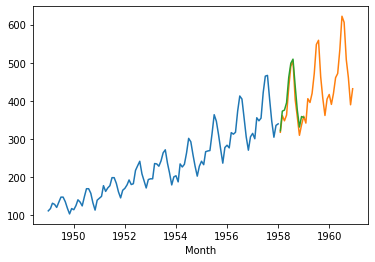

In [47]:
pred_series = my_model_gru.true_predict(train, is_best=False)
train.plot()
test.plot()
pred_series.shift(0).plot()

T = -40

=> loaded checkpoint (epoch 1500)


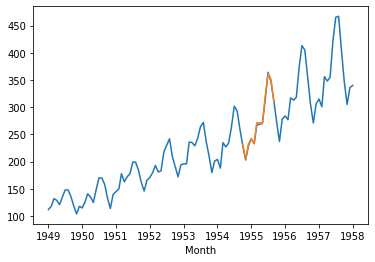

In [48]:
pred_series = my_model_gru.true_predict(train[:-40], is_best=False)
train.plot()
pred_series.plot()

T = end of test time series

=> loaded checkpoint (epoch 571)


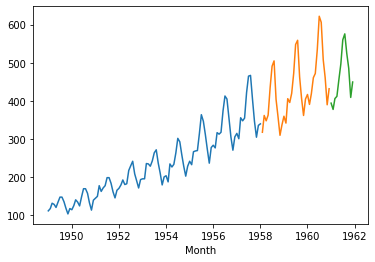

In [49]:
pred_series = my_model_gru.true_predict(test, is_best=True)
train.plot()
test.plot()
pred_series.shift(0).plot()

## monthly sunspot

In [50]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series2 = TimeSeries.from_dataframe(df2, 'Month', 'Sunspots')

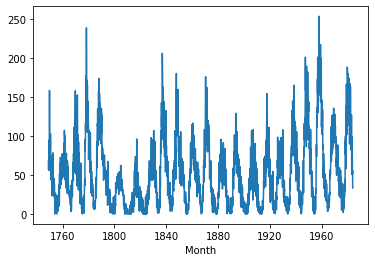

In [51]:
series2[:].plot()

In [52]:
from u8timeseries.models.statistics import check_seasonality, plot_acf

In [53]:
check_seasonality(series2, max_lag=240)

(True, 125)

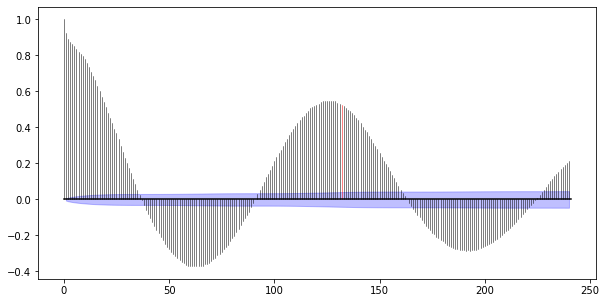

In [54]:
plot_acf(series2, 132, max_lag=240) # 11 years seasonality

In [85]:
test, train = training_split(series2, pd.Timestamp('19401001'))

In [97]:
INPUT_SIZE = 1
SEQ_LENGTH = 125
HIDDEN_SIZE = 10
OUTPUT_SIZE = 50
NUM_LAYERS = 3

In [98]:
my_model_sun = RNNModel('GRU', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=600, exp_name='sun_GRU', vis_tb=True)

In [99]:
my_model_sun.set_optimizer(torch.optim.Adam, learning_rate=1e-4)
my_model_sun.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=0.995)

In [100]:
my_model_sun.set_val_series(test)

In [101]:
my_model_sun.fit(train)  # 107

Training loss: 0.0188, validation loss: 0.0512


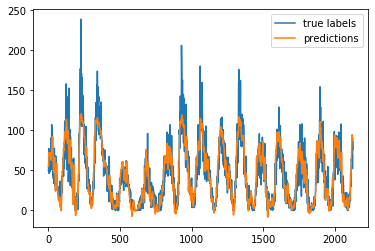

MSE: 775.064148


In [102]:
my_model_sun.plot_result_train()

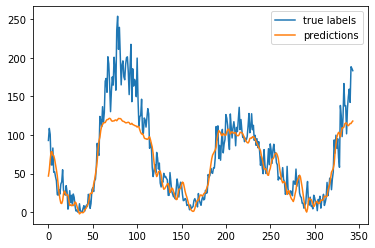

MSE: 2337.912842


In [103]:
my_model_sun.test_series(test)

=> loaded checkpoint (epoch 800)


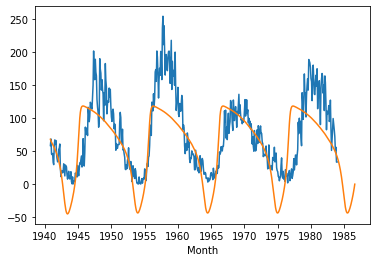

In [104]:
pred_series = my_model_sun.predict(train, 550, is_best=False)
test.plot()
pred_series.plot()

=> loaded checkpoint (epoch 791)


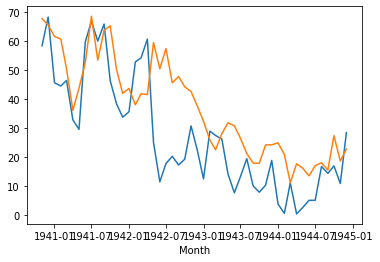

In [106]:
pred_series = my_model_sun.true_predict(train, is_best=True)
test[:50].plot()
pred_series.plot()